# Importing required modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer, pairwise_distances
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_utils import haversine_distance
import numpy as np
from utils.data_utils import save_test_predictions_in_kaggle_format

# Experiments to run with knn

This notebook contains 2 experiments using knn:
1. Vanilla KNN by passing our entire dataset
2. Custom KNN where we consider Haversine distance in place of regular euclidian distance since we have the latitude and longitude values

First we will try the Vanilla KNN with multiple K values and use the best K value in the second experiment

# Loading the cleaned dataset

In [2]:
datasets_path = "../../datasets/final"
train_path = f"{datasets_path}/train_clean.csv"
test_path = f"{datasets_path}/test_clean.csv"

#load dataframe
train_df = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)

In [4]:
#split the train df into train and val
y = train_df['monthly_rent']
X = train_df.drop(columns=['monthly_rent'])


In [5]:
# split it into train and val datasets from the train_df
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
X_train.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,distance_to_nearest_mall,...,town_pasir ris,town_punggol,town_queenstown,town_sembawang,town_sengkang,town_serangoon,town_tampines,town_toa payoh,town_woodlands,town_yishun
49578,0.866081,0.50,0.397790,0.603774,1.308722,103.796751,0.147207,0.326400,0.507243,0.097611,...,False,False,True,False,False,False,False,False,False,False
50763,0.767289,0.75,0.563536,0.339623,1.346522,103.734843,0.201964,0.068745,0.346423,0.682251,...,False,False,False,False,False,False,False,False,False,False
24147,0.933041,0.75,0.491713,0.490566,1.367566,103.951903,0.260956,0.060712,0.028869,0.249039,...,True,False,False,False,False,False,False,False,False,False
13290,0.599341,0.25,0.215470,0.396226,1.363576,103.745977,0.336514,0.071959,0.145460,0.647535,...,False,False,False,False,False,False,False,False,False,False
17890,0.198683,0.75,0.558011,0.547170,1.346176,103.757834,0.385762,0.162398,0.062420,0.461309,...,False,False,False,False,False,False,False,False,False,False


In [7]:
y_train.head()

49578    4000
50763    4000
24147    3550
13290    2750
17890    2000
Name: monthly_rent, dtype: int64

In [8]:
len(X_test)

30000

# 1. Vanilla KNN


## 1.1 Elbow curve to find out a good value for k

In [8]:
rms_values = []

start = 5
end = 300
step = 5
k_values = list(range(start, end, step))

for i in tqdm(k_values):
    knn_regressor = KNeighborsRegressor(n_neighbors=i)
    knn_regressor.fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_val)

    # Evaluate the model using Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)
    rms_values.append(mse ** 0.5)

100%|██████████| 59/59 [01:37<00:00,  1.65s/it]


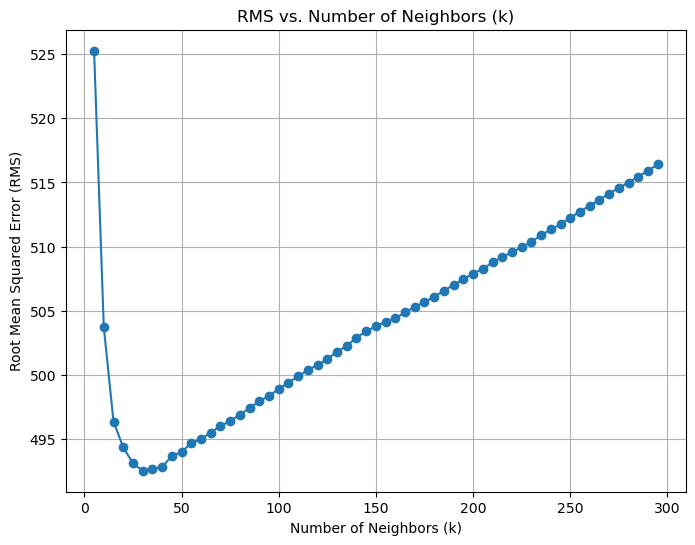

In [10]:
# plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, rms_values, marker='o', linestyle='-')
plt.title('RMS vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMS)')
plt.grid(True)
plt.show()

## 1.2 Doing grid search on other parameters keeping the best k fixed

In [11]:
# Doing grid search
param_grid = {
    'n_neighbors': [20, 25, 30, 35, 40],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40],  # Adjust as needed
    'p': [1, 2],  # For Manhattan and Euclidean distances
}

# Create the KNN regressor
knn_regressor = KNeighborsRegressor()

# Define the scoring metric (MSE)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object with verbose logging
grid_search = GridSearchCV(knn_regressor, param_grid, scoring=mse_scorer, cv=5, verbose=3)

# Fit the model to the data (X_train, y_train)
grid_search.fit(X_train, y_train)

# Get the best estimator (model)
best_knn_regressor = grid_search.best_estimator_

# Make predictions on the validation data
y_pred = best_knn_regressor.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE)
rms = mean_squared_error(y_val, y_pred) ** 0.5

# Print the best hyperparameters and RMSE
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Root Mean Squared Error: {rms}")

'''
Best Hyperparameters: {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
Root Mean Squared Error: 491.7355716745773
'''

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=uniform;, score=-249434.841 total time=   2.1s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=uniform;, score=-248059.367 total time=   1.7s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=uniform;, score=-250011.930 total time=   1.7s
[CV 4/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=uniform;, score=-248302.294 total time=   1.7s
[CV 5/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=uniform;, score=-259316.692 total time=   1.7s
[CV 1/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=distance;, score=-279604.482 total time=   1.7s
[CV 2/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=distance;, score=-271676.862 total time=   1.6s
[CV 3/5] END algorithm=auto, leaf_size=30, n_neighbors=20, p=1, weights=distance;, score=-272768.532 t

## Making predictions for the vanilla knn

In [21]:
y_pred_test = best_knn_regressor.predict(X_test)

save_test_predictions_in_kaggle_format(y_pred_test, "vanilla-knn", True)

,Id,Predicted
0,0,2828.333333
1,1,2771.666667
2,2,3588.333333
3,3,1941.666667
4,4,2815.000000
...,...,...
29995,29995,3020.000000
29996,29996,2891.666667
29997,29997,2681.666667
29998,29998,3398.333333


# 2. Custom KNN with Haversine

Here we will use a custom KNN Metric to find euclidean distance for the rest of the points, but haversine only for the latitude and longitude

In [9]:
import numba
from numba import jit, float64
import math

@jit(float64(float64, float64, float64, float64), nopython=True)
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Compute the distances between 2 lat and long

    :param lat1:
    :param lon1:
    :param lat2:
    :param lon2:
    :return:
    '''
    # Radius of the Earth in kilometers
    earth_radius_km = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate the distance
    distance = earth_radius_km * c

    # returns distance in meters
    return distance * 1000

In [10]:
@jit(nopython=True)
def custom_distance_with_haversine_local(X1, X2, lat_long_indices, remaining_indices):
    # Calculate the Haversine distance for latitude and longitude columns
    lat_X1, long_X1 = X1[lat_long_indices]
    lat_X2, long_X2 = X2[lat_long_indices]
    haversine_dist = haversine_distance(lat_X1, long_X1, lat_X2, long_X2) / 1000  # to get distance in km
    haversine_dist = np.array([haversine_dist]).reshape((1, -1))

    # Calculate the Euclidean distance for all columns
    X1_rem = X1[remaining_indices].reshape((1, -1))
    X2_rem = X2[remaining_indices].reshape((1, -1))
    euclidean_dist = np.linalg.norm(X1_rem - X2_rem)

    # Calculate manhattan
    manhattan_dist = np.sum(np.abs(X1_rem - X2_rem))

    # Combine the two distance matrices
    combined_dist = euclidean_dist + haversine_dist + manhattan_dist

    return combined_dist[0, 0]


lat_long_indices = np.array([4, 5])
remaining_indices = np.array(list(filter(lambda i: i not in lat_long_indices, list(range(44)))))

# Create the KNN Regressor with the custom distance metric (using the best metrics from earlier
knn_regressor = KNeighborsRegressor(n_neighbors=30, weights="uniform", algorithm="ball_tree", leaf_size=40,
                                    metric=custom_distance_with_haversine_local,
                                    metric_params={'lat_long_indices': lat_long_indices,
                                                   'remaining_indices': remaining_indices})

# Fit and use the KNN Regressor as usual
print(f"Fitting the Custom KNN")
knn_regressor.fit(X_train, y_train)

print(f"Making val predictions")
y_pred = knn_regressor.predict(X_val)
print(f"Finished val predictions")

# Calculate the Root Mean Squared Error (RMSE)
rms = mean_squared_error(y_val, y_pred) ** 0.5

print(f"The RMS values with haversine implementation is {rms}")

Fitting the Custom KNN
Making val predictions
Finished val predictions
The RMS values with haversine implementation is 496.3471045446601


# Making predictions for the Haversine KNN

In [11]:
print("Making predictions on test data")
y_pred_test = knn_regressor.predict(X_test)
print("Finished predictions on test data")

save_test_predictions_in_kaggle_format(y_pred_test, "haversine-knn", True)
print("Saved to disk!")

Making predictions on test data
Finished predictions on test data
Saved to disk!
